<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_fss/blob/main/Simulacao4_Cenario2_FSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FSS - Fish School Search ou Pesquisa de Cardumes de Peixes é um método proposto pelos pesquisadores Fernando Buarque e Carmelo Filho em 2008 para resolver problemas de otimização inspirado no comportamento de cardumes, onde os mecanismos de alimentação e movimento coordenados dos peixes foram usados ​​como inspiração para criar os operadores de busca, tendo como ideia central a de fazer os peixes nadarem em direção ao gradiente positivo para se alimentar e ganhar peso, dessa forma os peixes mais pesados ​​têm mais influência no processo de busca como um todo, o que faz com que o baricentro do cardume se desloque para lugares melhores no espaço de busca ao longo das iterações, onde todos os peixes realizam buscas locais e o cardume agrega informações sociais.

Bastos-Filho, C.J.A.; Lima-Neto, F.B.; Lins, A.J.C.C.; Nascimento, A.I.S.; Lima, M.P. A novel search algorithm based on fish school behavior. IEEE Xplore. https://doi.org/10.1109/ICSMC.2008.4811695, 2008.

In [ ]:
#instala biblioteca Orange Canvas
!pip install Orange3

In [11]:
#importa bibliotecas
import random
import math
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn import metrics
import Orange

In [4]:
#define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
CARDUME = 20 #tamanho da população correspondente ao número de peixes no aquário (tamanho do cardume)
E1 = -15 #extremo esquerdo eixo x
E2 = 15 #extremo direito eixo x
E3 = -100 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E3,E4] #(bound) determina os valores maximos e minimos do espaço de busca (tamenho do aquário)
FCUSTO = 'rosenbrock' #(fitness) função custo que pode ser uma esfera ou parábola (rosenbrock) ou outra função custo que defina a densidade de alimentação dos peixes no aquário
PASSO_INICIAL = 0.01 #(swimming inicial) conduz os movimentos dos peixes
PASSO_FINAL = 0.000001 #(swimming final) conduz os movimentos dos peixes
PEIXES = [] #(swarm) array da criação dos peixes

In [ ]:
#importa dados
from google.colab import files  
files.upload()

In [ ]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/dados.csv")

In [ ]:
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #exploração dos domínios dos atributos (campos da base de dados)
print("Qtde de Registros:", len(dados)) #exploração dos dados (quantidade de registros da base de dados)
i = 0 #exibição dos 5 primeiros registros para análise dos dados importados
for d in dados[:10]:
  i += 1
  print(i, d)

In [ ]:
#cria arrays das dimensões do problema a ser otimizado
periodo = []
complexidade = [] #1-muito baixa complexidade;2-baixa complexidade;3-média complexidade;4-alta complexidade;e,5-muito alta complexidade
pagina = []
prazo = []
revisao = []
entrega = []
i = 0
for d in dados[:CARDUME]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  print("id:",i,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])
  i += 1

In [10]:
#peixe - unidade base da otimização, posicionado numa determinada posição no espaço de busca do problema, representando uma possível solução para o problema
class Peixe:
  def __init__(self):
    self.posicao = [0.0] * DIMENSOES
    self.fitness = 0.0
    self.dif_distancia = [0.0] * DIMENSOES
    self.dif_fitness = 0.0
    self.peso = 1.0

In [12]:
#função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fitness(problema, posicoes, alfa=0, beta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(posicoes[i+1] - posicoes[i]**2)**2 + (1-posicoes[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += posicoes[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in posicao]))
  elif problema == 'rota':
    denominador = sum([(caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta for caminho in posicoes])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(posicoes)  for _ in posicoes]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta) / denominador for caminho in posicoes]
    total = choice(posicoes, 1, p=distribuicao_probabilidades)[0]
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#inicializa população (cardume)
PEIXES = []
for i in range(CARDUME):
  cpx = complexidade[i]
  pag = pagina[i]
  PEIXES.append(Peixe())
  posicoes = []
  for j in range(DIMENSOES):
    if (j == 0):
      posicao = cpx
    elif (j == 1):
      posicao = pag
    else:
      print('Dimensão não encontrado!')
    posicoes.append(posicao)
  PEIXES[-1].posicao = posicoes
  PEIXES[-1].fitness = fitness(FCUSTO, PEIXES[-1].posicao)
for i in range(CARDUME):
  print("i:",i,"posição:",list(PEIXES[i].posicao),"otimização:",PEIXES[i].fitness)

In [ ]:
#posiciona os perixes no espaço de busca (aquário)
print("Plano Cartesiano")
plt.axis([E1,E2,E3,E4])
plt.plot(0,0, marker='*', markersize=15, color='b')
for i in range (CARDUME):
  peixe = PEIXES[i]
  d1,d2 = zip(peixe.posicao)
  plt.plot(d1,d2, marker='o')
plt.show()

In [15]:
#calcula movimento individual - cada peixe escolhe aleatoriamente uma nova posição em sua vizinhança e a avalia com a função aptidão ou objetivo (fitness)
def movimento_individual(populacao, passo_atual, problema):
  for peixe in populacao:
    nova_posicao = []
    novo_fitness = 0.0
    for dimensao in range(DIMENSOES):
      #calcula a nova posicao
      direcao = random.random()*2 - 1
      mudanca = direcao*passo_atual*(LIMITES[1] - LIMITES[0])
      nova_posicao.append(peixe.posicao[dimensao] + mudanca)
      #verifica se ultrapassa os limites superior e inferior
      if nova_posicao[-1] > LIMITES[1]:
        nova_posicao[-1] = LIMITES[1]
      elif nova_posicao[-1] < LIMITES[0]:
        nova_posicao[-1] = LIMITES[0]         
    #verifica o fitness da nova posicao
    novo_fitness = fitness(problema, nova_posicao)
    #o peixe escolhe a melhor posicao e salva a diferenca de fitness e de posicao
    if(novo_fitness < peixe.fitness):
      peixe.dif_fitness = peixe.fitness - novo_fitness
      peixe.fitness = novo_fitness
      for dim in range(DIMENSOES):
        peixe.dif_distancia[dim] = nova_posicao[dim] - peixe.posicao[dim]
        peixe.posicao[dim] = nova_posicao[dim]
    else:
      peixe.dif_fitness = 0
      for dim in range(DIMENSOES):
        peixe.dif_distancia[dim] = 0

In [16]:
#calcula movimento instintivo - somente peixes que realizaram movimentos individuais com sucesso poderão determinar a direção do movimento do cardume (swimming)
def movimento_instintivo(populacao):
  total_diferenca_fitness = 0.0
  vetor_i = [0.0] * DIMENSOES
  for peixe in populacao:
    total_diferenca_fitness += peixe.dif_fitness
    for i in range(DIMENSOES):
      vetor_i[i] += peixe.dif_distancia[i]*peixe.dif_fitness
  if total_diferenca_fitness != 0:
    for i in range(DIMENSOES):
      vetor_i[i] /= total_diferenca_fitness
    for peixe in populacao:
      for i in range(DIMENSOES):
        peixe.posicao[i] += vetor_i[i]
        #verifica se ultrapassa os limites superior e inferior
        if peixe.posicao[i] > LIMITES[1]:
          peixe.posicao[i] = LIMITES[1]
        elif peixe.posicao[i] < LIMITES[0]:
          peixe.posicao[i] = LIMITES[0]

In [17]:
#calcula movimento volitivo - poder de escolha baseado na taxa geral de sucesso do cardume (swimming)
def movimento_volitivo(populacao, baricentro, mudanca_peso, passo):
  for peixe in populacao:
    for i in range(DIMENSOES):
      direcao = random.random()
      if mudanca_peso < 0:
        peixe.posicao[i] -= 2*passo*direcao*(LIMITES[1] - LIMITES[0])* ((peixe.posicao[i] - baricentro[i])/distancia(peixe.posicao, baricentro))
      else:
        peixe.posicao[i] += 2*passo*direcao*(LIMITES[1] - LIMITES[0])* ((peixe.posicao[i] - baricentro[i])/distancia(peixe.posicao, baricentro))
      #verifica se ultrapassa os limites superior e inferior
      if peixe.posicao[i] > LIMITES[1]:
        peixe.posicao[i] = LIMITES[1]
      elif peixe.posicao[i] < LIMITES[0]:
        peixe.posicao[i] = LIMITES[0]

In [18]:
#calcula operação de alimentação - cada peixe pode aumentar seu peso dependendo da taxa de sucesso obtida pelo movimento indiviaul (feeding)
def alimentacao(populacao):
  maior_diferenca_fitness = 0
  mudanca_peso = 0
  for peixe in populacao:
    mudanca_peso += peixe.peso
    if peixe.dif_fitness > maior_diferenca_fitness:
      maior_diferenca_fitness = peixe.dif_fitness
  if maior_diferenca_fitness != 0:
    for peixe in populacao:
      peixe.peso += peixe.dif_fitness/maior_diferenca_fitness
      mudanca_peso -= peixe.peso
    return mudanca_peso
  else:
    return 0

In [19]:
#calcula baricentro - ponto de aplicação da força de gravidade de acordo com a força-peso (memória do cardume)
def calcular_baricentro(populacao):
  baricentro = [0.0] * DIMENSOES
  peso_total = 0.0
  for peixe in populacao:
    peso_total += peixe.peso
    for i in range(DIMENSOES):
      baricentro[i] += peixe.peso * peixe.posicao[i]
  for i in range(DIMENSOES):
    baricentro[i] /= peso_total
  return baricentro

In [20]:
#calcula distância
def distancia(lista_1, lista_2):
  dist = 0.0
  for i in range(len(lista_1)):
    dist += (lista_1[i] - lista_2[i])**2
  return math.sqrt(dist)

In [21]:
#atualiza passo - conduz os movimentos dos peixes
def atualizar_passo(passo):
    return passo - ((PASSO_INICIAL - PASSO_FINAL) / ITERACOES)

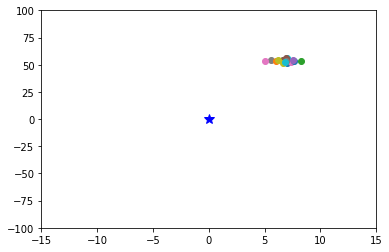

Melhor Ponto: 42.660236690185215

Iteração: 34


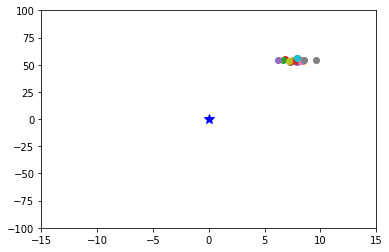

Melhor Ponto: 42.660236690185215

Iteração: 35


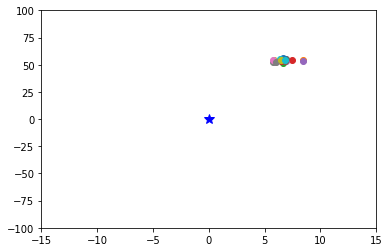

Melhor Ponto: 42.660236690185215

Iteração: 36


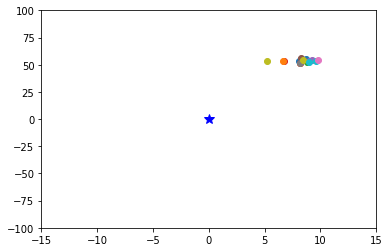

Melhor Ponto: 42.660236690185215

Iteração: 37


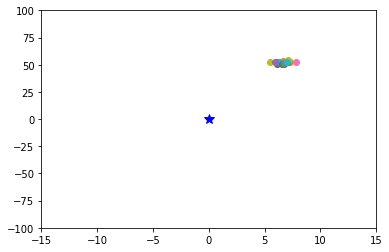

Melhor Ponto: 39.454570134218685

Iteração: 38


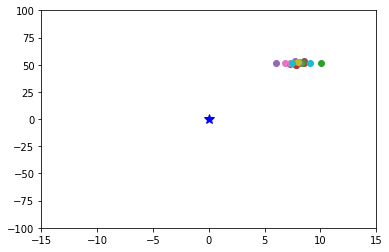

Melhor Ponto: 39.454570134218685

Iteração: 39


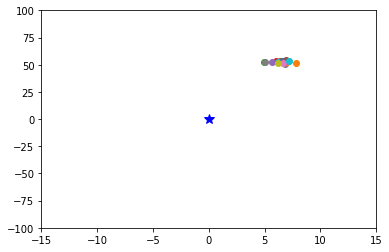

Melhor Ponto: 39.454570134218685

Iteração: 40


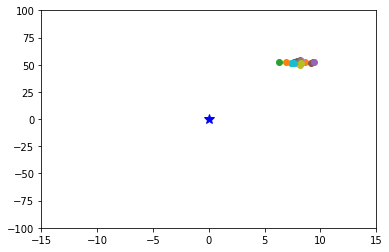

Melhor Ponto: 39.454570134218685

Iteração: 41


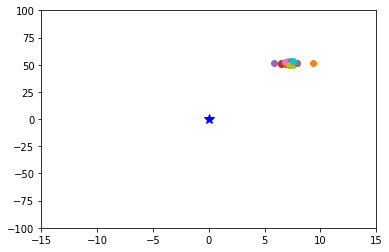

Melhor Ponto: 39.454570134218685

Iteração: 42


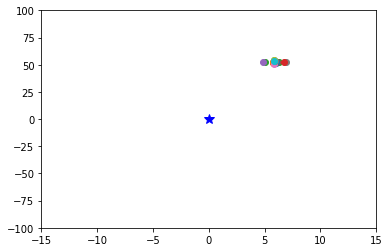

Melhor Ponto: 39.454570134218685

Iteração: 43


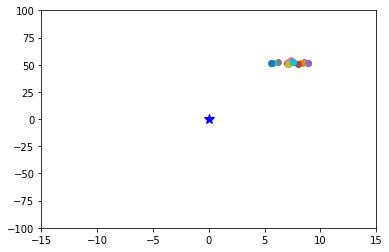

Melhor Ponto: 39.13328422627941

Iteração: 44


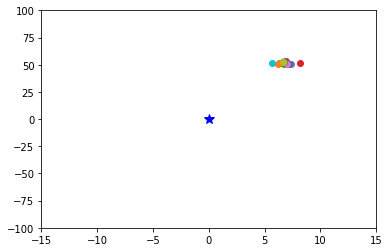

Melhor Ponto: 39.13328422627941

Iteração: 45


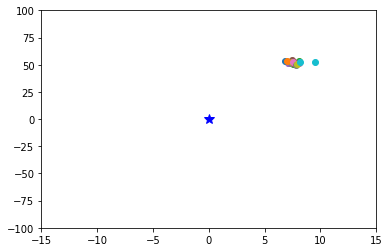

Melhor Ponto: 39.13328422627941

Iteração: 46


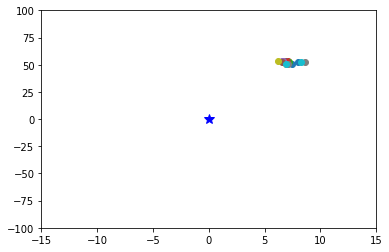

Melhor Ponto: 39.13328422627941

Iteração: 47


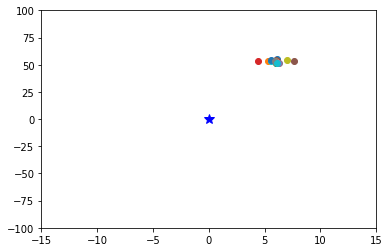

Melhor Ponto: 39.13328422627941

Iteração: 48


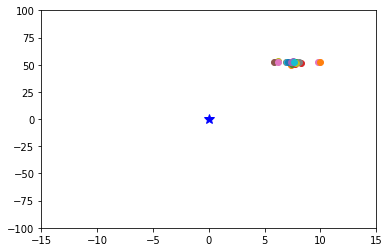

Melhor Ponto: 39.13328422627941

Iteração: 49


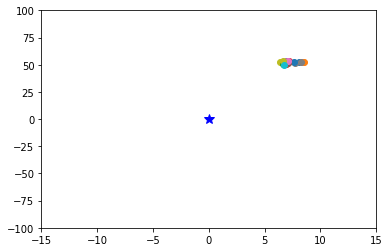

Melhor Ponto: 39.13328422627941

Iteração: 50


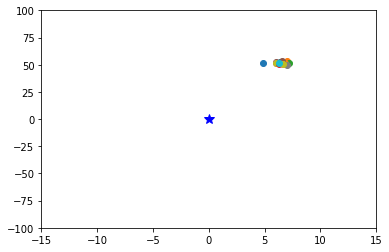

Melhor Ponto: 39.13328422627941

Iteração: 51


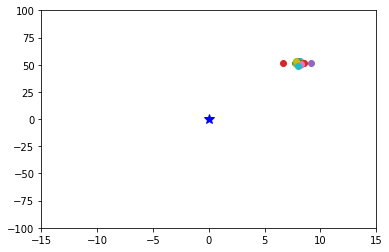

Melhor Ponto: 39.13328422627941

Iteração: 52


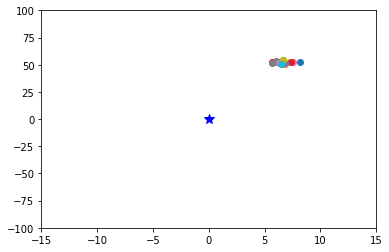

Melhor Ponto: 39.13328422627941

Iteração: 53


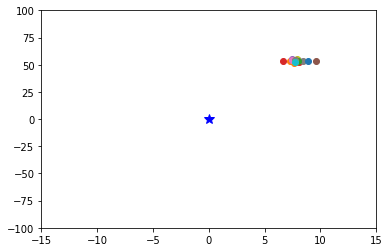

Melhor Ponto: 39.13328422627941

Iteração: 54


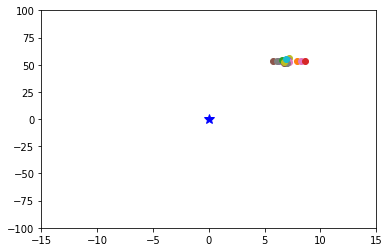

Melhor Ponto: 39.13328422627941

Iteração: 55


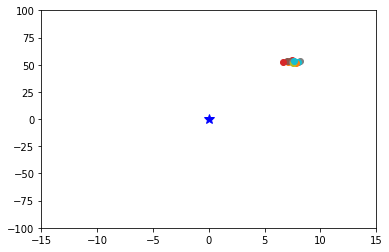

Melhor Ponto: 39.13328422627941

Iteração: 56


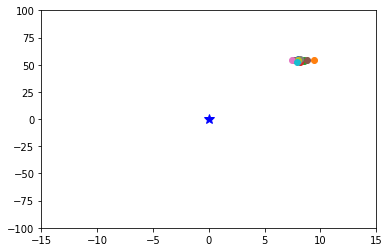

Melhor Ponto: 39.13328422627941

Iteração: 57


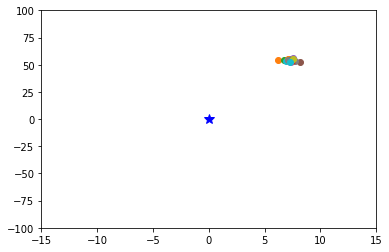

Melhor Ponto: 39.13328422627941

Iteração: 58


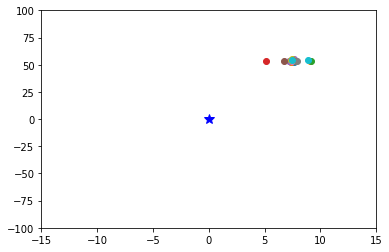

Melhor Ponto: 39.13328422627941

Iteração: 59


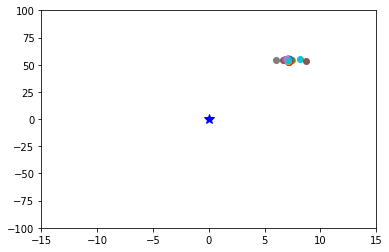

Melhor Ponto: 39.13328422627941

Iteração: 60


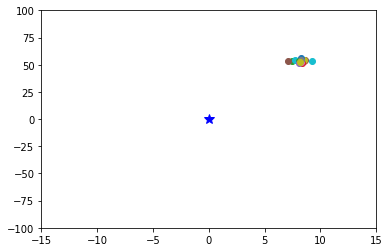

Melhor Ponto: 39.13328422627941

Iteração: 61


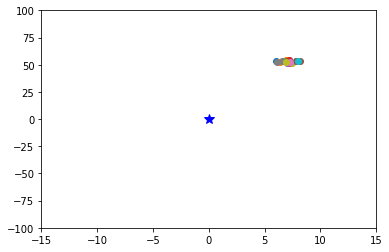

Melhor Ponto: 39.13328422627941

Iteração: 62


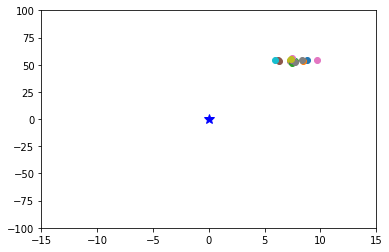

Melhor Ponto: 39.13328422627941

Iteração: 63


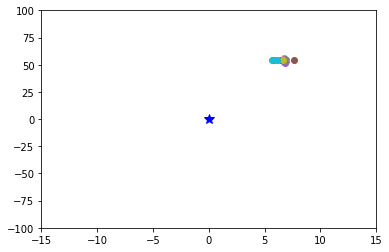

Melhor Ponto: 39.13328422627941

Iteração: 64


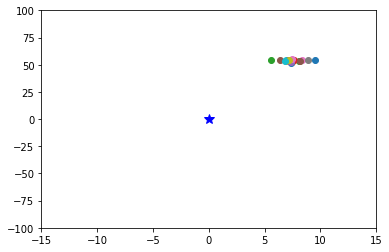

Melhor Ponto: 39.13328422627941

Iteração: 65


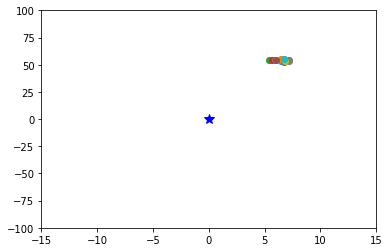

Melhor Ponto: 39.13328422627941

Iteração: 66


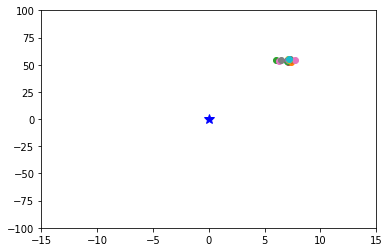

Melhor Ponto: 39.13328422627941

Iteração: 67


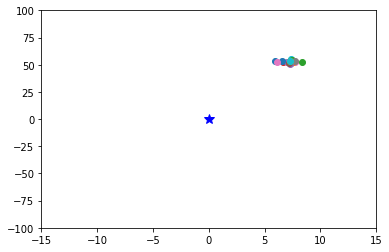

Melhor Ponto: 38.58207599489345

Iteração: 68


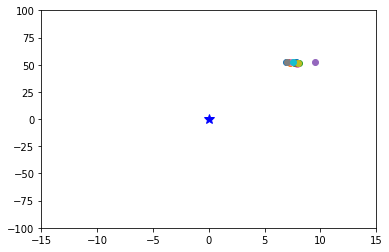

Melhor Ponto: 38.58207599489345

Iteração: 69


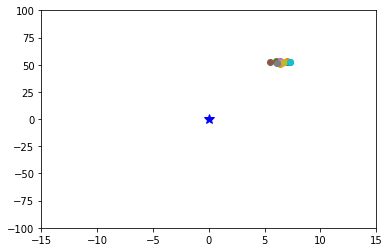

Melhor Ponto: 38.58207599489345

Iteração: 70


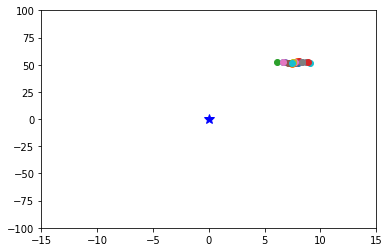

Melhor Ponto: 38.58207599489345

Iteração: 71


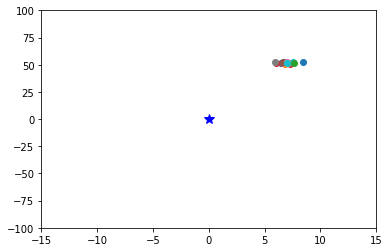

Melhor Ponto: 38.58207599489345

Iteração: 72


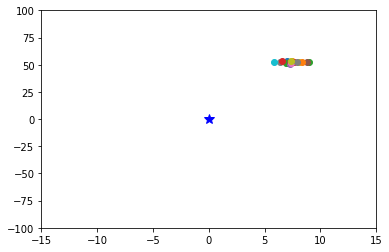

Melhor Ponto: 38.58207599489345

Iteração: 73


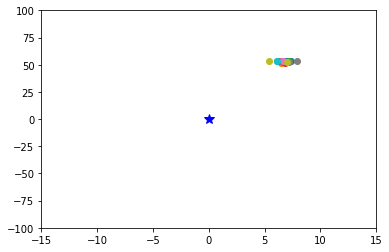

Melhor Ponto: 38.58207599489345

Iteração: 74


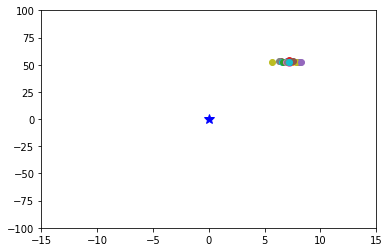

Melhor Ponto: 38.58207599489345

Iteração: 75


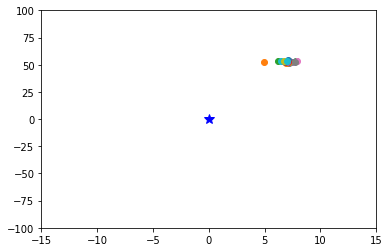

Melhor Ponto: 38.58207599489345

Iteração: 76


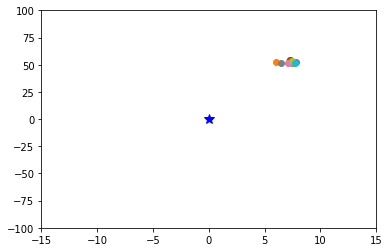

Melhor Ponto: 38.58207599489345

Iteração: 77


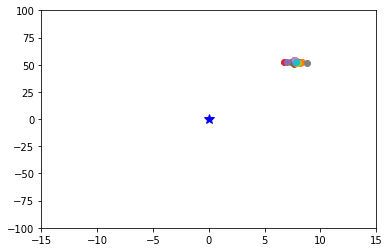

Melhor Ponto: 38.58207599489345

Iteração: 78


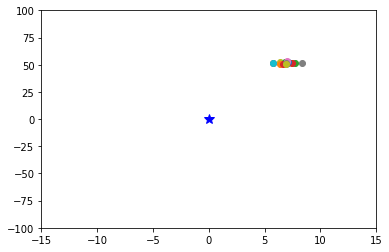

Melhor Ponto: 38.58207599489345

Iteração: 79


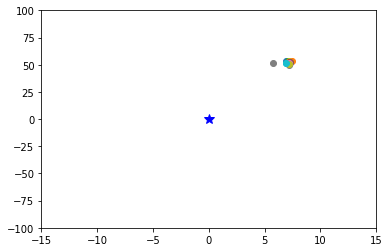

Melhor Ponto: 38.58207599489345

Iteração: 80


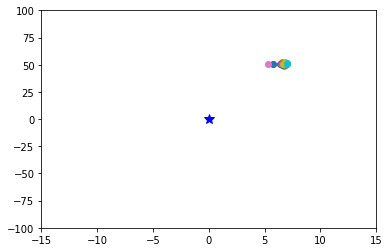

Melhor Ponto: 38.58207599489345

Iteração: 81


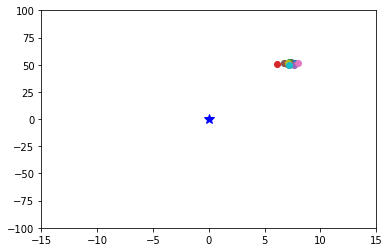

Melhor Ponto: 37.8681301513115

Iteração: 82


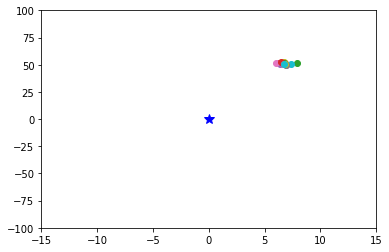

Melhor Ponto: 37.8681301513115

Iteração: 83


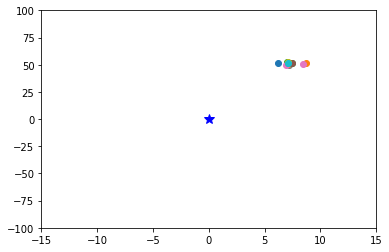

Melhor Ponto: 37.8681301513115

Iteração: 84


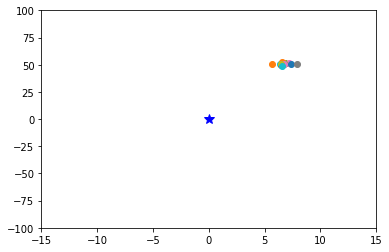

Melhor Ponto: 37.8681301513115

Iteração: 85


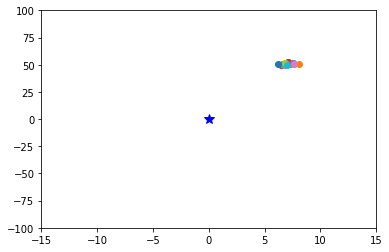

Melhor Ponto: 37.8681301513115

Iteração: 86


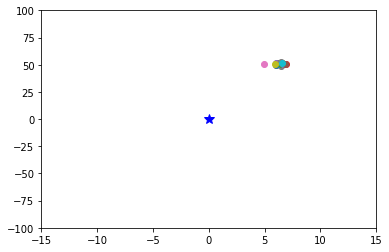

Melhor Ponto: 37.8681301513115

Iteração: 87


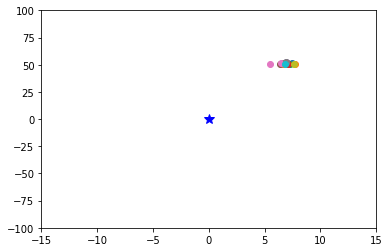

Melhor Ponto: 37.8681301513115

Iteração: 88


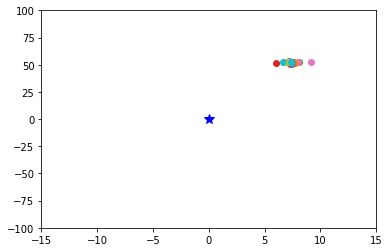

Melhor Ponto: 37.8681301513115

Iteração: 89


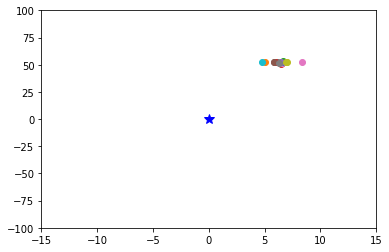

Melhor Ponto: 37.8681301513115

Iteração: 90


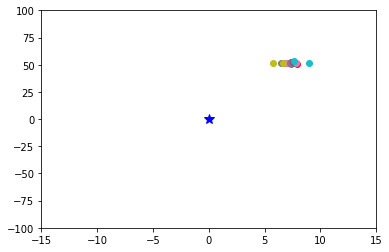

Melhor Ponto: 37.8681301513115

Iteração: 91


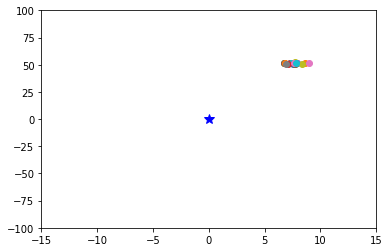

Melhor Ponto: 37.57990051379324

Iteração: 92


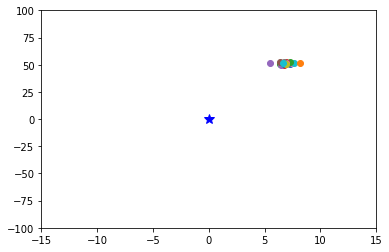

Melhor Ponto: 37.57990051379324

Iteração: 93


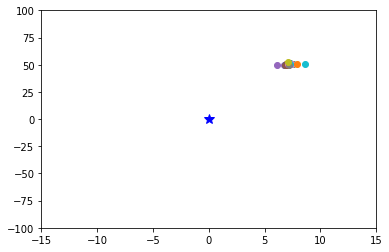

Melhor Ponto: 37.57990051379324

Iteração: 94


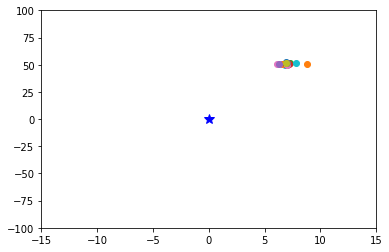

Melhor Ponto: 37.57990051379324

Iteração: 95


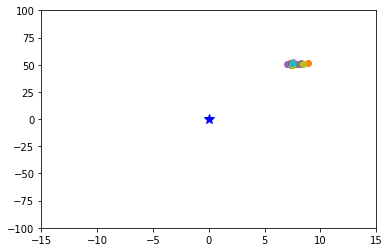

Melhor Ponto: 37.57990051379324

Iteração: 96


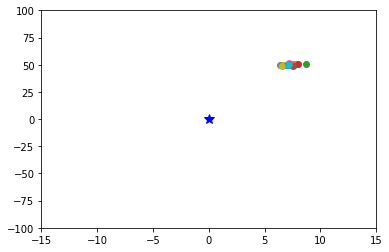

Melhor Ponto: 37.119701469378406

Iteração: 97


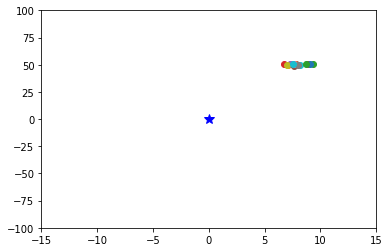

Melhor Ponto: 37.119701469378406

Iteração: 98


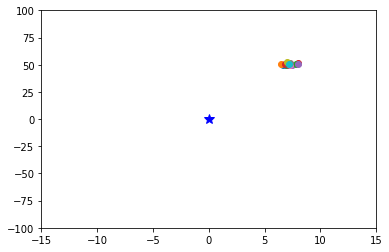

Melhor Ponto: 37.119701469378406

Iteração: 99


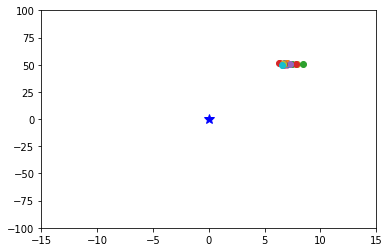

Melhor Ponto: 37.119701469378406

Iteração: 100


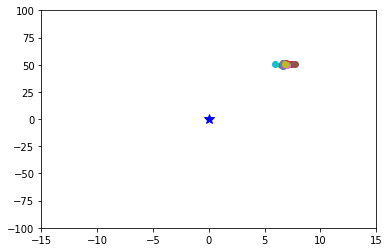

Melhor Ponto: 37.119701469378406

Iteração: 101


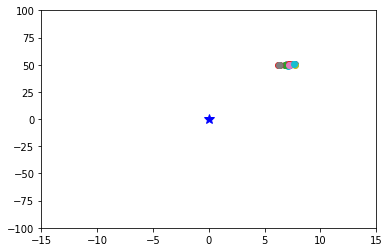

Melhor Ponto: 37.119701469378406

Iteração: 102


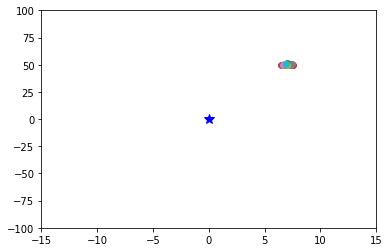

Melhor Ponto: 36.62207241554429

Iteração: 103


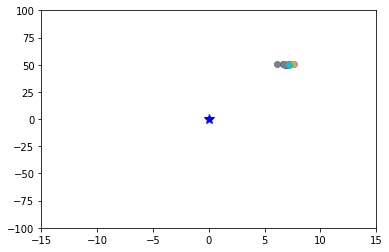

Melhor Ponto: 36.62207241554429

Iteração: 104


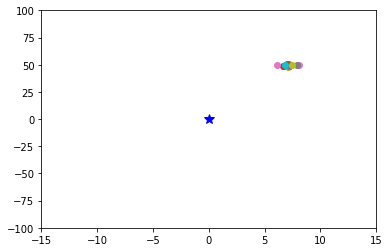

Melhor Ponto: 36.62207241554429

Iteração: 105


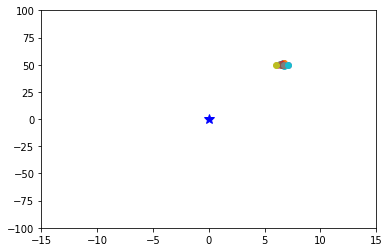

Melhor Ponto: 36.62207241554429

Iteração: 106


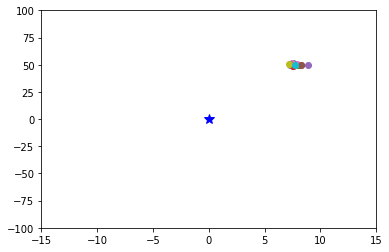

Melhor Ponto: 36.62207241554429

Iteração: 107


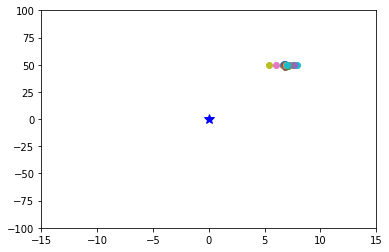

Melhor Ponto: 36.62207241554429

Iteração: 108


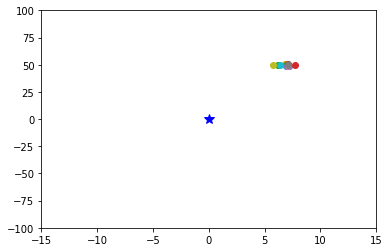

Melhor Ponto: 36.62207241554429

Iteração: 109


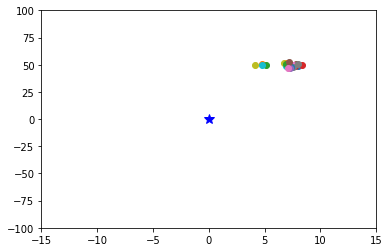

Melhor Ponto: 36.62207241554429

Iteração: 110


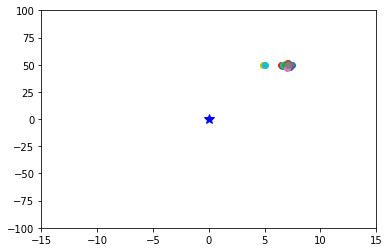

Melhor Ponto: 36.62207241554429

Iteração: 111


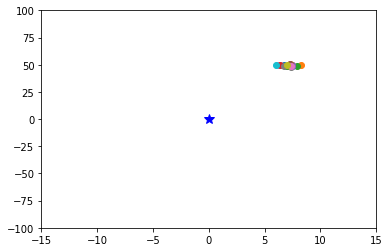

Melhor Ponto: 36.62207241554429

Iteração: 112


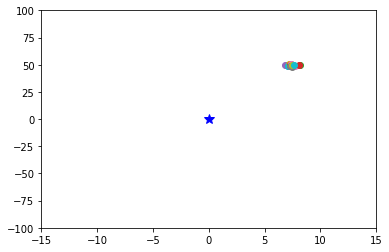

Melhor Ponto: 36.62207241554429

Iteração: 113


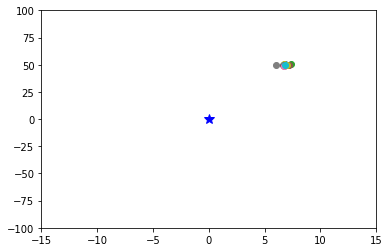

Melhor Ponto: 36.62207241554429

Iteração: 114


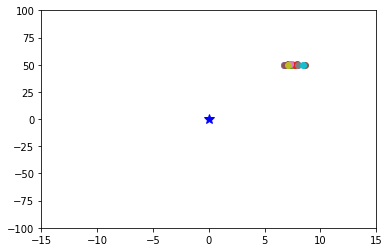

Melhor Ponto: 36.62207241554429

Iteração: 115


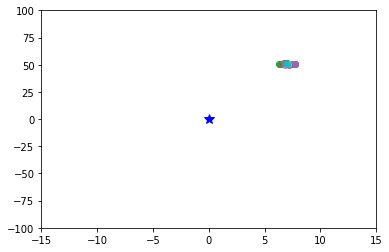

Melhor Ponto: 36.62207241554429

Iteração: 116


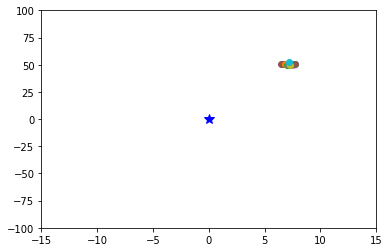

Melhor Ponto: 36.62207241554429

Iteração: 117


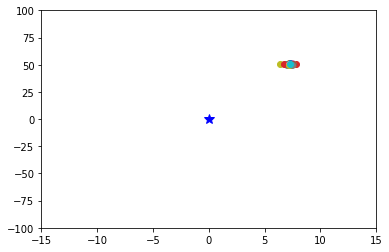

Melhor Ponto: 36.62207241554429

Iteração: 118


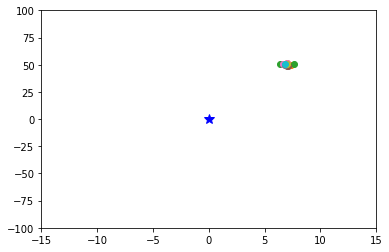

Melhor Ponto: 36.62207241554429

Iteração: 119


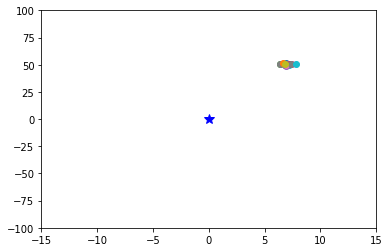

Melhor Ponto: 36.62207241554429

Iteração: 120


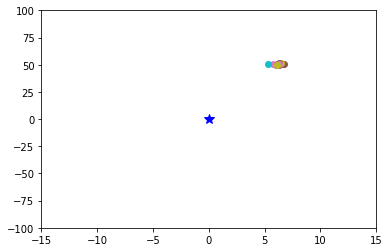

Melhor Ponto: 36.62207241554429

Iteração: 121


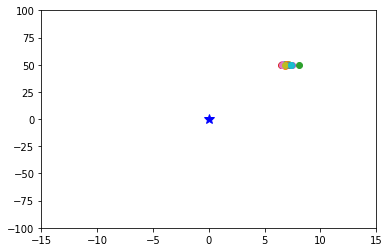

Melhor Ponto: 36.62207241554429

Iteração: 122


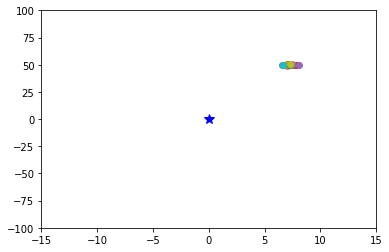

Melhor Ponto: 36.62207241554429

Iteração: 123


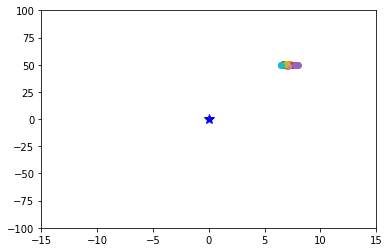

Melhor Ponto: 36.62207241554429

Iteração: 124


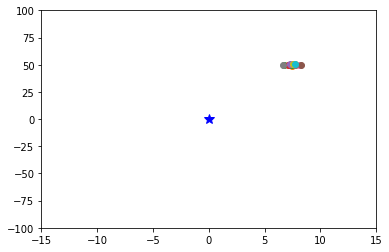

Melhor Ponto: 36.62207241554429

Iteração: 125


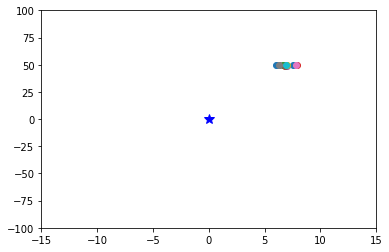

Melhor Ponto: 36.62207241554429

Iteração: 126


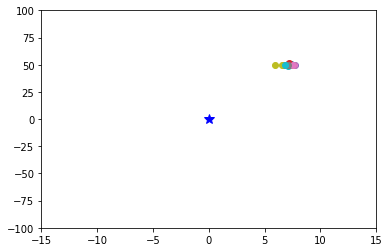

Melhor Ponto: 36.62207241554429

Iteração: 127


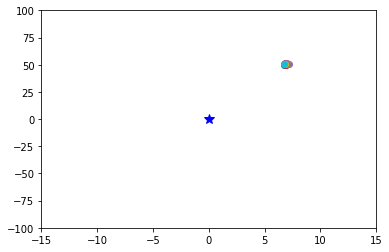

Melhor Ponto: 36.62207241554429

Iteração: 128


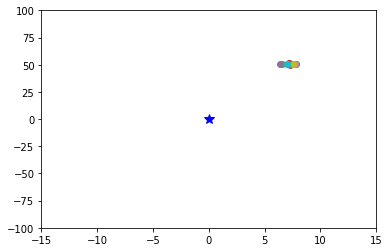

Melhor Ponto: 36.62207241554429

Iteração: 129


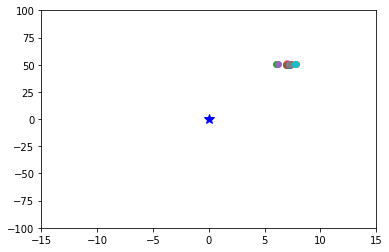

Melhor Ponto: 36.62207241554429

Iteração: 130


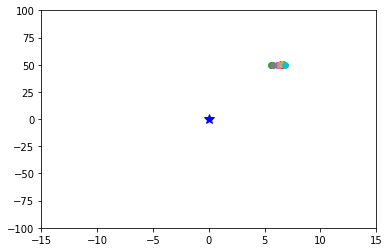

Melhor Ponto: 36.62207241554429

Iteração: 131


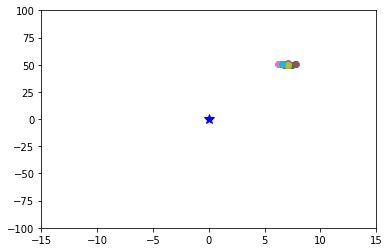

Melhor Ponto: 36.62207241554429

Iteração: 132


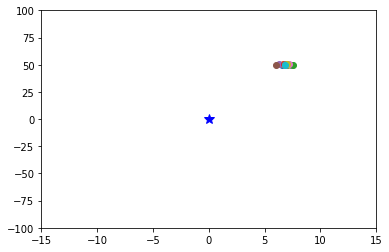

Melhor Ponto: 36.62207241554429

Iteração: 133


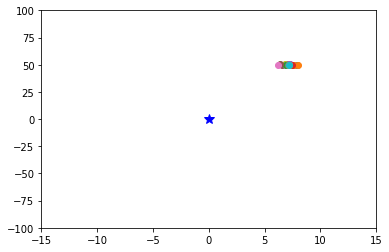

Melhor Ponto: 36.62207241554429

Iteração: 134


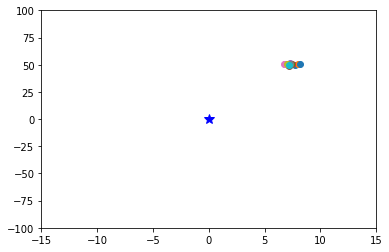

Melhor Ponto: 36.62207241554429

Iteração: 135


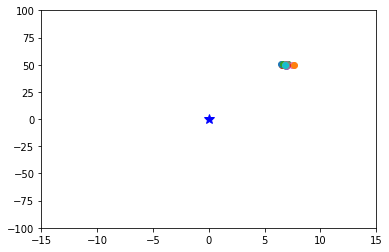

Melhor Ponto: 36.62207241554429

Iteração: 136


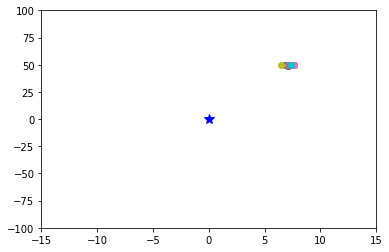

Melhor Ponto: 36.62207241554429

Iteração: 137


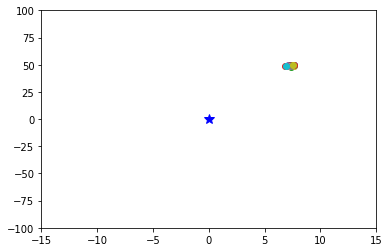

Melhor Ponto: 36.62207241554429

Iteração: 138


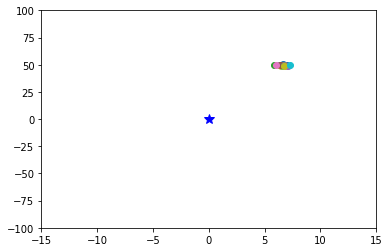

Melhor Ponto: 36.62207241554429

Iteração: 139


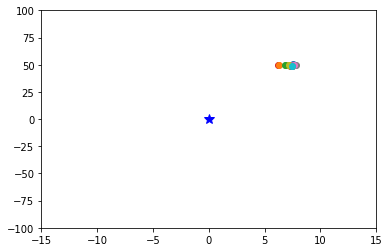

Melhor Ponto: 36.62207241554429

Iteração: 140


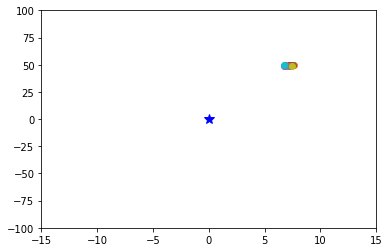

Melhor Ponto: 36.62207241554429

Iteração: 141


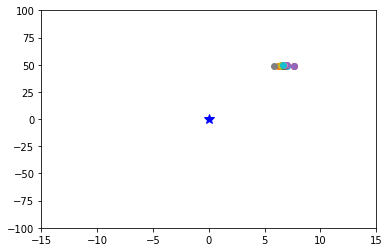

Melhor Ponto: 36.62207241554429

Iteração: 142


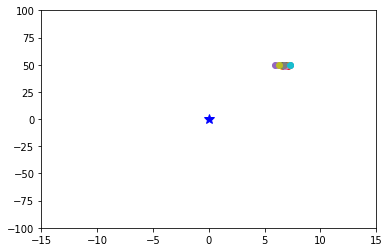

Melhor Ponto: 36.62207241554429

Iteração: 143


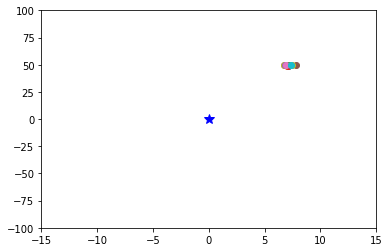

Melhor Ponto: 36.40564736150563

Iteração: 144


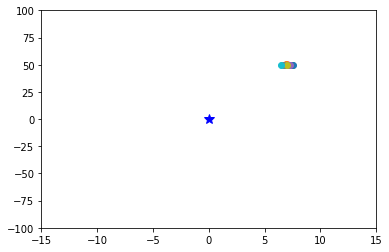

Melhor Ponto: 36.40564736150563

Iteração: 145


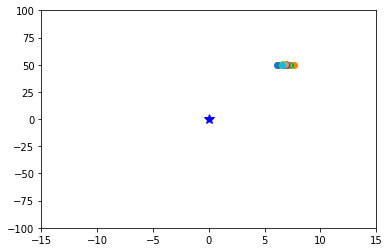

Melhor Ponto: 36.40564736150563

Iteração: 146


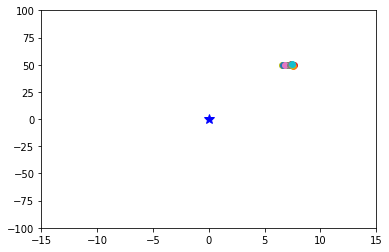

Melhor Ponto: 36.40564736150563

Iteração: 147


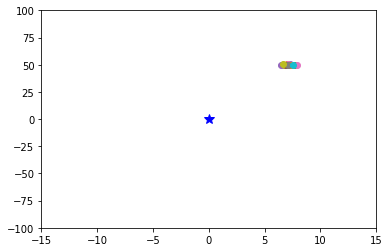

Melhor Ponto: 36.40564736150563

Iteração: 148


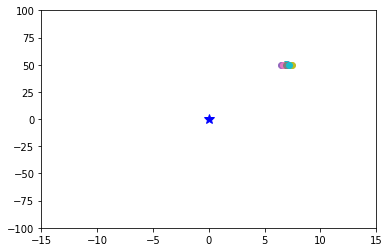

Melhor Ponto: 36.40564736150563

Iteração: 149


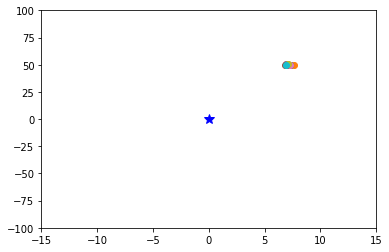

Melhor Ponto: 36.40564736150563

Iteração: 150


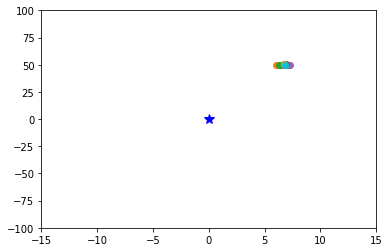

Melhor Ponto: 36.40564736150563

Iteração: 151


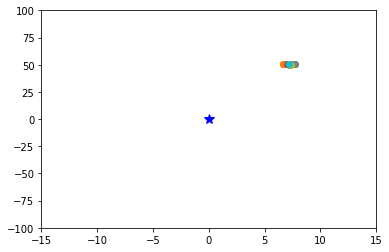

Melhor Ponto: 36.40564736150563

Iteração: 152


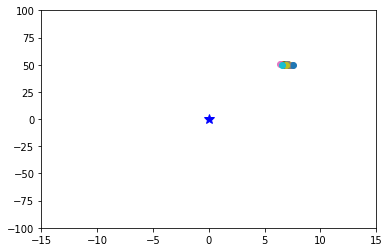

Melhor Ponto: 36.40564736150563

Iteração: 153


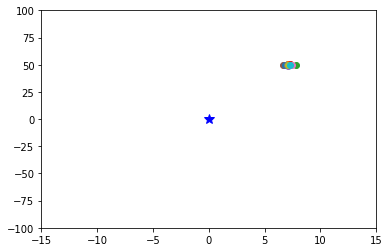

Melhor Ponto: 36.40564736150563

Iteração: 154


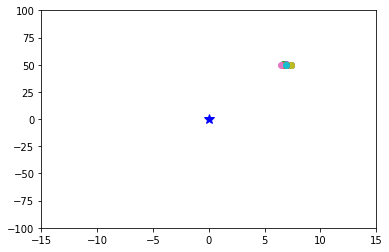

Melhor Ponto: 36.40564736150563

Iteração: 155


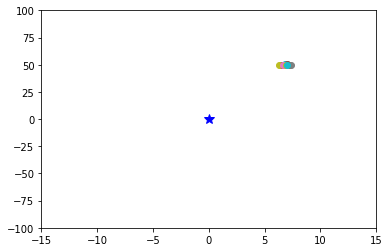

Melhor Ponto: 36.40564736150563

Iteração: 156


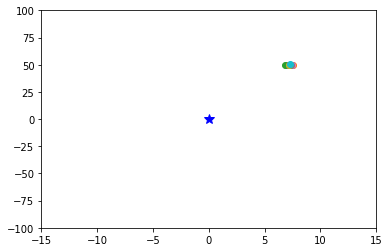

Melhor Ponto: 36.40564736150563

Iteração: 157


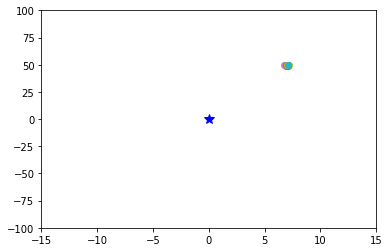

Melhor Ponto: 36.40564736150563

Iteração: 158


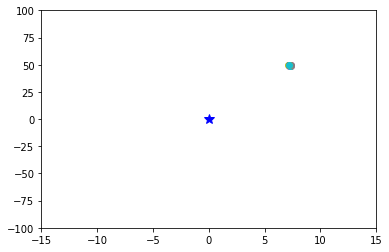

Melhor Ponto: 36.40564736150563

Iteração: 159


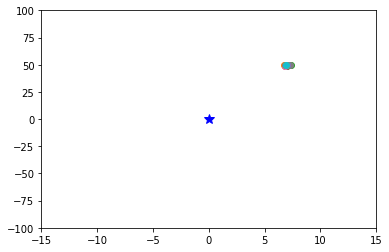

Melhor Ponto: 36.40564736150563

Iteração: 160


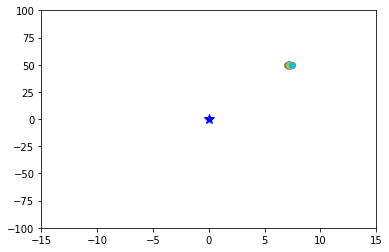

Melhor Ponto: 36.40564736150563

Iteração: 161


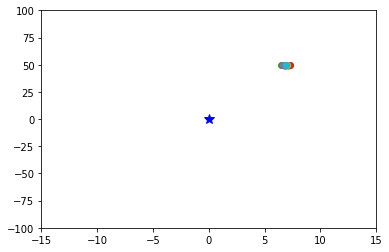

Melhor Ponto: 36.40564736150563

Iteração: 162


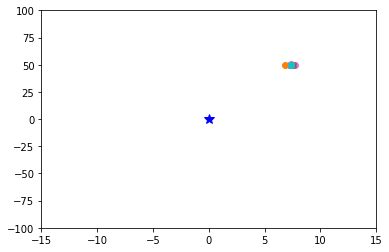

Melhor Ponto: 36.40564736150563

Iteração: 163


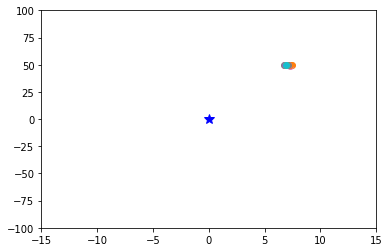

Melhor Ponto: 36.40564736150563

Iteração: 164


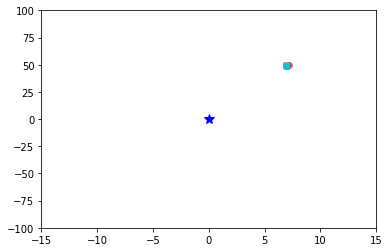

Melhor Ponto: 36.32789113363818

Iteração: 165


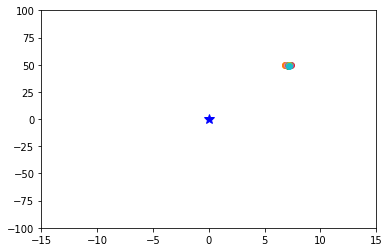

Melhor Ponto: 36.32789113363818

Iteração: 166


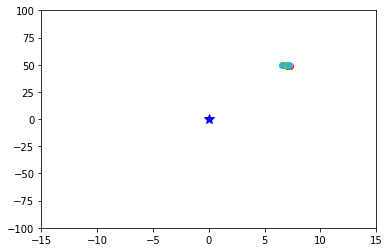

Melhor Ponto: 36.30115055910598

Iteração: 167


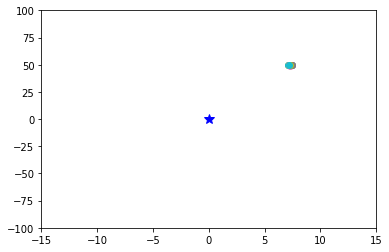

Melhor Ponto: 36.30115055910598

Iteração: 168


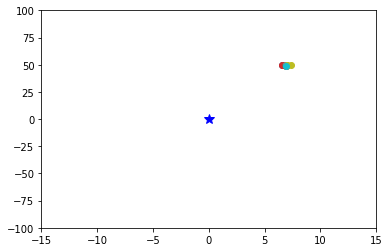

Melhor Ponto: 36.30115055910598

Iteração: 169


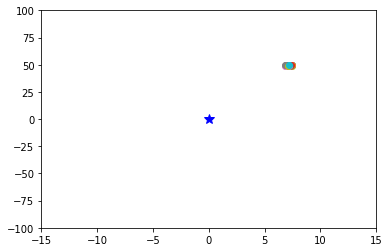

Melhor Ponto: 36.30115055910598

Iteração: 170


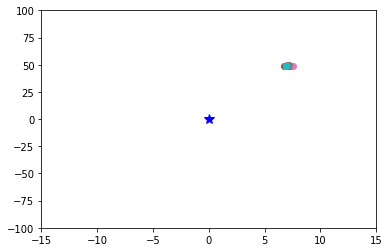

Melhor Ponto: 36.30115055910598

Iteração: 171


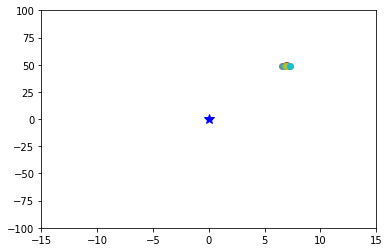

Melhor Ponto: 35.93531290101355

Iteração: 172


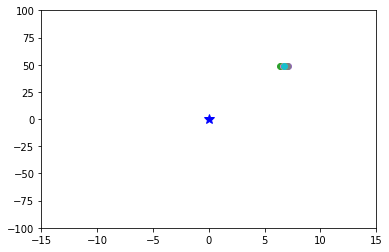

Melhor Ponto: 35.93531290101355

Iteração: 173


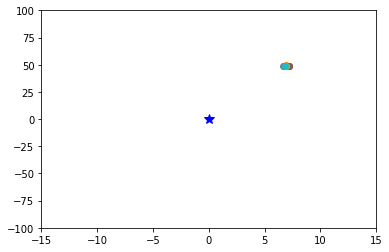

Melhor Ponto: 35.93531290101355

Iteração: 174


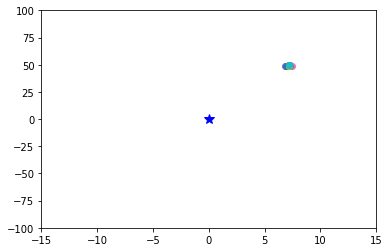

Melhor Ponto: 35.93531290101355

Iteração: 175


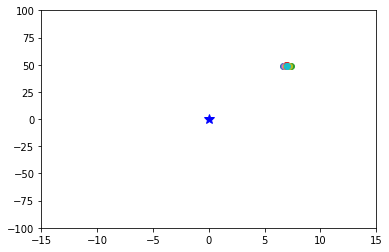

Melhor Ponto: 35.93531290101355

Iteração: 176


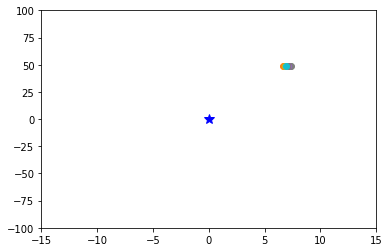

Melhor Ponto: 35.93531290101355

Iteração: 177


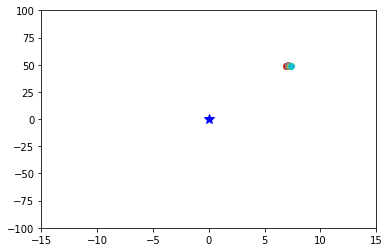

Melhor Ponto: 35.93531290101355

Iteração: 178


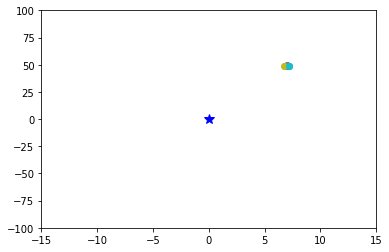

Melhor Ponto: 35.93531290101355

Iteração: 179


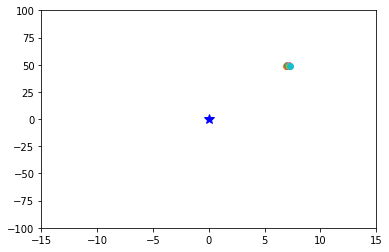

Melhor Ponto: 35.93531290101355

Iteração: 180


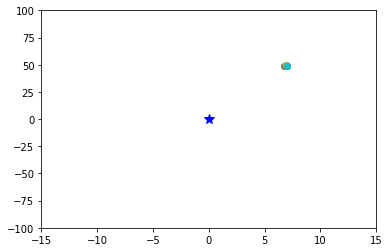

Melhor Ponto: 35.93531290101355

Iteração: 181


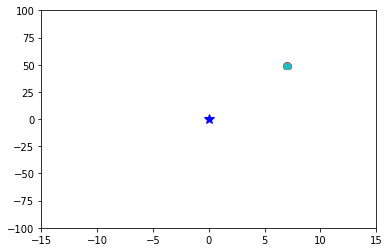

Melhor Ponto: 35.93531290101355

Iteração: 182


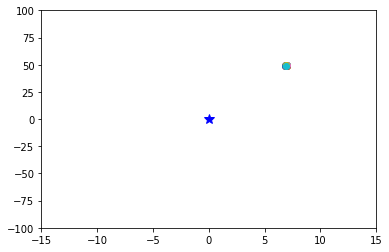

Melhor Ponto: 35.93531290101355

Iteração: 183


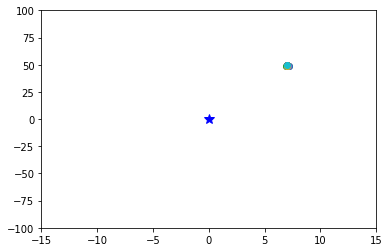

Melhor Ponto: 35.93531290101355

Iteração: 184


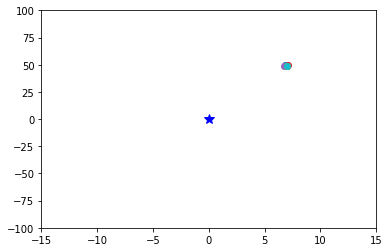

Melhor Ponto: 35.93531290101355

Iteração: 185


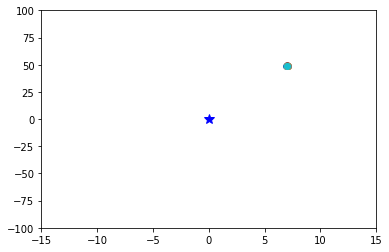

Melhor Ponto: 35.93531290101355

Iteração: 186


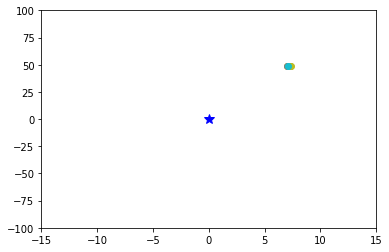

Melhor Ponto: 35.93531290101355

Iteração: 187


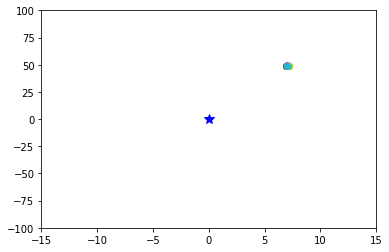

Melhor Ponto: 35.93531290101355

Iteração: 188


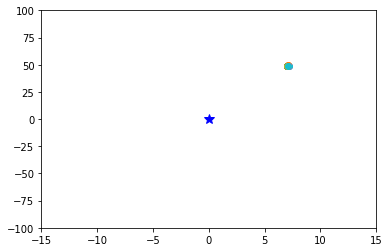

Melhor Ponto: 35.93531290101355

Iteração: 189


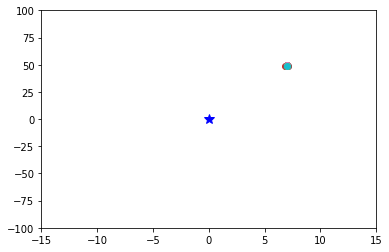

Melhor Ponto: 35.93531290101355

Iteração: 190


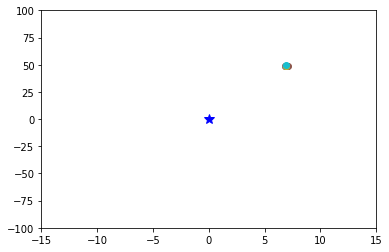

Melhor Ponto: 35.93531290101355

Iteração: 191


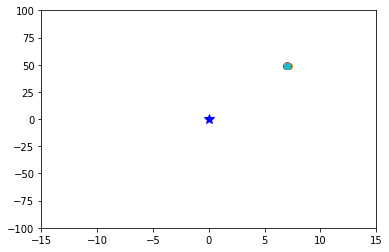

Melhor Ponto: 35.93531290101355

Iteração: 192


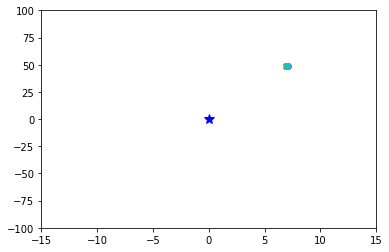

Melhor Ponto: 35.93531290101355

Iteração: 193


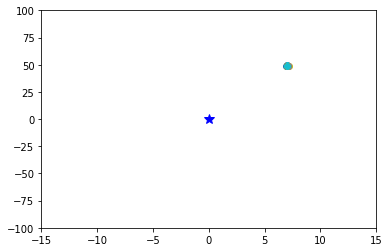

Melhor Ponto: 35.93531290101355

Iteração: 194


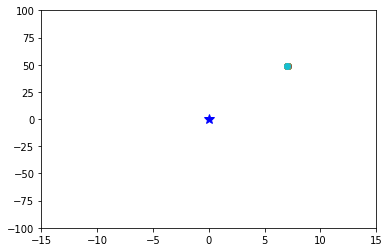

Melhor Ponto: 35.93531290101355

Iteração: 195


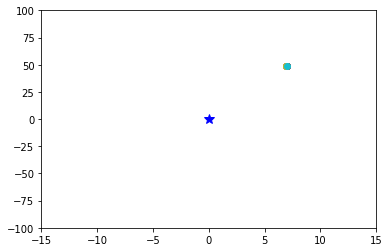

Melhor Ponto: 35.93531290101355

Iteração: 196


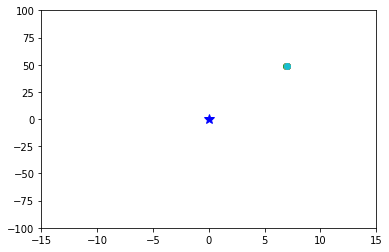

Melhor Ponto: 35.93531290101355

Iteração: 197


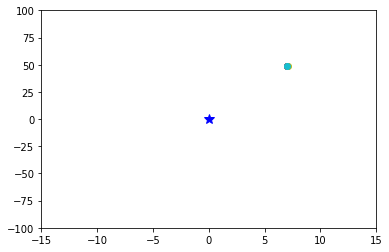

Melhor Ponto: 35.93531290101355

Iteração: 198


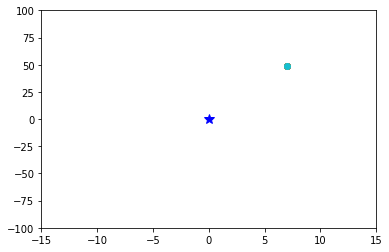

Melhor Ponto: 35.93531290101355

Iteração: 199


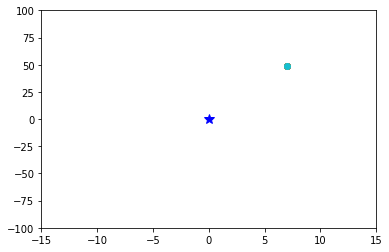

Melhor Ponto: 35.93531290101355

Iteração: 200


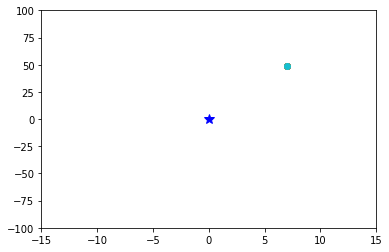

Melhor Ponto: 35.93531290101355



In [23]:
#otimiza as posições
passo = PASSO_INICIAL
melhor_fitness = 999999999999
fitness_tempo = []
populacao = PEIXES
#print("Melhor fitness inicial: ", melhor_fitness)
for i in range(ITERACOES):
  print("Iteração: {:.0f}".format(i+1))
  movimento_individual(populacao, passo, FCUSTO)
  mudanca_peso = alimentacao(populacao)
  movimento_instintivo(populacao)
  baricentro = calcular_baricentro(populacao)
  movimento_volitivo(populacao, baricentro, mudanca_peso, passo)
  passo = atualizar_passo(passo)
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, color='b')
  for i in range(CARDUME):
    populacao[i].fitness = fitness(FCUSTO, populacao[i].posicao)
  for i in populacao:
    if melhor_fitness > i.fitness:
      melhor_fitness = i.fitness
  fitness_tempo.append(melhor_fitness)
  #exibe o enxame - mostrando no gráfico as posições atuais de cada paixe no aquário
  for i in range (CARDUME):
    p = populacao[i]
    d1,d2 = zip(p.posicao)
    plt.plot(d1,d2, marker='o')
  #plt.plot(melhor_fitness, marker='x', markersize=15, color='r') #ponto gbest
  plt.show()
  print('Melhor Ponto:',melhor_fitness)
  print("")
#print("Melhor fitness final: ", melhor_fitness)

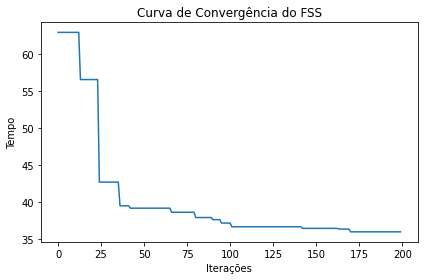

In [24]:
#exibe a curva de convergência dos peixes
x = []
y = []
for i in range(len(fitness_tempo)):
  x.append(i)
  y.append(fitness_tempo[i])
plt.plot(x, y)
plt.title("Curva de Convergência do FSS")
plt.xlabel("Iterações")
plt.ylabel("Tempo")
plt.tight_layout()

In [30]:
#exibe das posições e otimizações calculadas
posicao_inicial = []
posicao_otimizada = []
for i in range(CARDUME):
  posicao_inicial.append(PEIXES[i].posicao)
  posicao_otimizada.append(PEIXES[i].fitness)
  print("i:",i,"posição:",posicao_inicial[i],"otimização:",posicao_otimizada[i])
#y = []
#ỹ = []
#for i in range(CARDUME):
#  y.append(int(PEIXES[i].posicao[0]))
#  ỹ.append(int(PEIXES[i].fitness))
#print('A:', metrics.accuracy_score(y,ỹ))
#print('P:', metrics.precision_score(y,ỹ,average='macro'))
#print('R:', metrics.recall_score(y,ỹ,average='macro'))
#print('F:', metrics.f1_score(y,ỹ,average='macro'))

i: 0 posição: [7.014779596123266, 49.14073476107116] otimização: 36.61844331075465
i: 1 posição: [7.0121787287768065, 49.14208535292596] otimização: 36.22788996837576
i: 2 posição: [7.011664212485738, 49.13001864618284] otimização: 36.251772065422614
i: 3 posição: [7.0072215341269315, 49.12545273391273] otimização: 36.14575521327978
i: 4 posição: [7.01896565564257, 49.150666453537156] otimização: 37.55533777181026
i: 5 posição: [7.0139484117269975, 49.146878724809234] otimização: 36.40370927128081
i: 6 posição: [7.011352634112539, 49.136765606616954] otimização: 36.18609017519319
i: 7 posição: [7.011600069832972, 49.133634664880816] otimização: 36.22286145372956
i: 8 posição: [7.017811559966043, 49.139218599207865] otimização: 37.434208000221425
i: 9 posição: [7.000241442561916, 49.143194036994686] otimização: 37.95768675605463
i: 10 posição: [7.0171661934033125, 49.14024020756245] otimização: 37.213927094321456
i: 11 posição: [7.01507349449182, 49.138460928268024] otimização: 36.71102